# Quickstart
Installs the realspace_tb package and calculates the orbital Hall conductivity of a graphene flake via the orbital polarization current.

In [1]:
# If realspace_tb is not yet installed, run the following.
# Assuming you are in the /examples directory of the repository,
# else change the relative path from '..'.
%pip install -e ..

Obtaining file:///Users/leonard/dev/projects/university/orbitronics_research_project
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for realspace_tb (pyproject.toml) ... done
  Created wheel for realspace_tb: filename=realspace_tb-0.1-0.editable-py3-none-any.whl size=2684 sha256=a3e67ace6f896bce62ad6e1a7cf7e3c1e83bf100d39ba65f1a124219f49581b4
  Stored in directory: /private/var/folders/2f/qsk40ts91rs8dfrbwykc6d080000gn/T/pip-ephem-wheel-cache-3jrgu9j3/wheels/9f/58/e4/ee6166b96636b31fb047f8712656325a05a996aba04989ca17
Successfully built realspace_tb
  Attempting uninstall: realspace_tb
    Found existing installation: realspace_tb 0.1
    Uninstalling realspace_tb-0.1:
      Successfully uninstalled realspace_tb-0.1

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip insta

In [2]:
import realspace_tb as tb
from realspace_tb import orbitronics_2d as orb2d
import numpy as np
tb.backend.set_backend(use_gpu=False)  # Set to True to use GPU acceleration if cupy is available

In [3]:
H = orb2d.LinearFieldHamiltonian(
    # Graphene-like system
    geometry=orb2d.HoneycombLatticeGeometry(Lx=11, Ly=20),  
    # homogeneous AC field via onsite potentials
    field_amplitude=orb2d.RampedACFieldAmplitude(
        E0=1e-3, omega=1.0, T_ramp=2 * np.pi, direction=np.array([0, 1])
    ),  # Ramp up to field amplitude E0=1e-3 in y-direction
)

In [4]:
# Initial state: superposition of eigenstates with Energy <= 0
rho = H.ground_state_density_matrix(fermi_level=0.0)

Calculating eigenvalues at t=0...


In [5]:
T = 2 * np.pi / H.field_amplitude.omega  # Period of the AC field
T_ramp = H.field_amplitude.T_ramp  # Ramp-up time of the field
cycles = 10  # Number of cycles to simulate
dt = T / 100  # Time step size

# Evolve rho in time with RK4 solver and observe orbital polarization
orb_pol = orb2d.observables.OrbitalPolarizationObservable(
    H.geometry, measurement_start_time=T_ramp
)

# Store ~20 frames for an animation of the latest period
animation = orb2d.observables.LatticeFrameObservable(
    H.geometry,
    measurement_start_time=T_ramp + (cycles - 1) * T,
    measurement_stride=int(T / dt / 20),
)

tb.RK4NeumannSolver().evolve(
    rho, # density matrix is modified in place
    H, # Hamiltonian
    dt=dt, # time step size
    total_time=T_ramp + cycles * T, # total simulation time: ramp-up, then cycles * period
    tau=10.0, # relaxation time
    observables=[orb_pol, animation] # measure polarization and animation frames
)

  0%|          | 0/1099 [00:00<?, ?it/s]

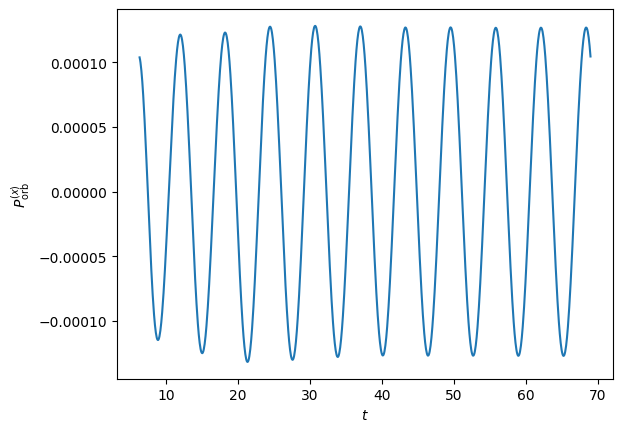

In [6]:
# Plot orbital polarization (x-comp.) over time
import matplotlib.pyplot as plt

plt.plot(orb_pol.measurement_times, orb_pol.values[:, 0])
plt.xlabel("$t$")
plt.ylabel(r"$P_\mathrm{orb}^{(x)}$")
plt.show()

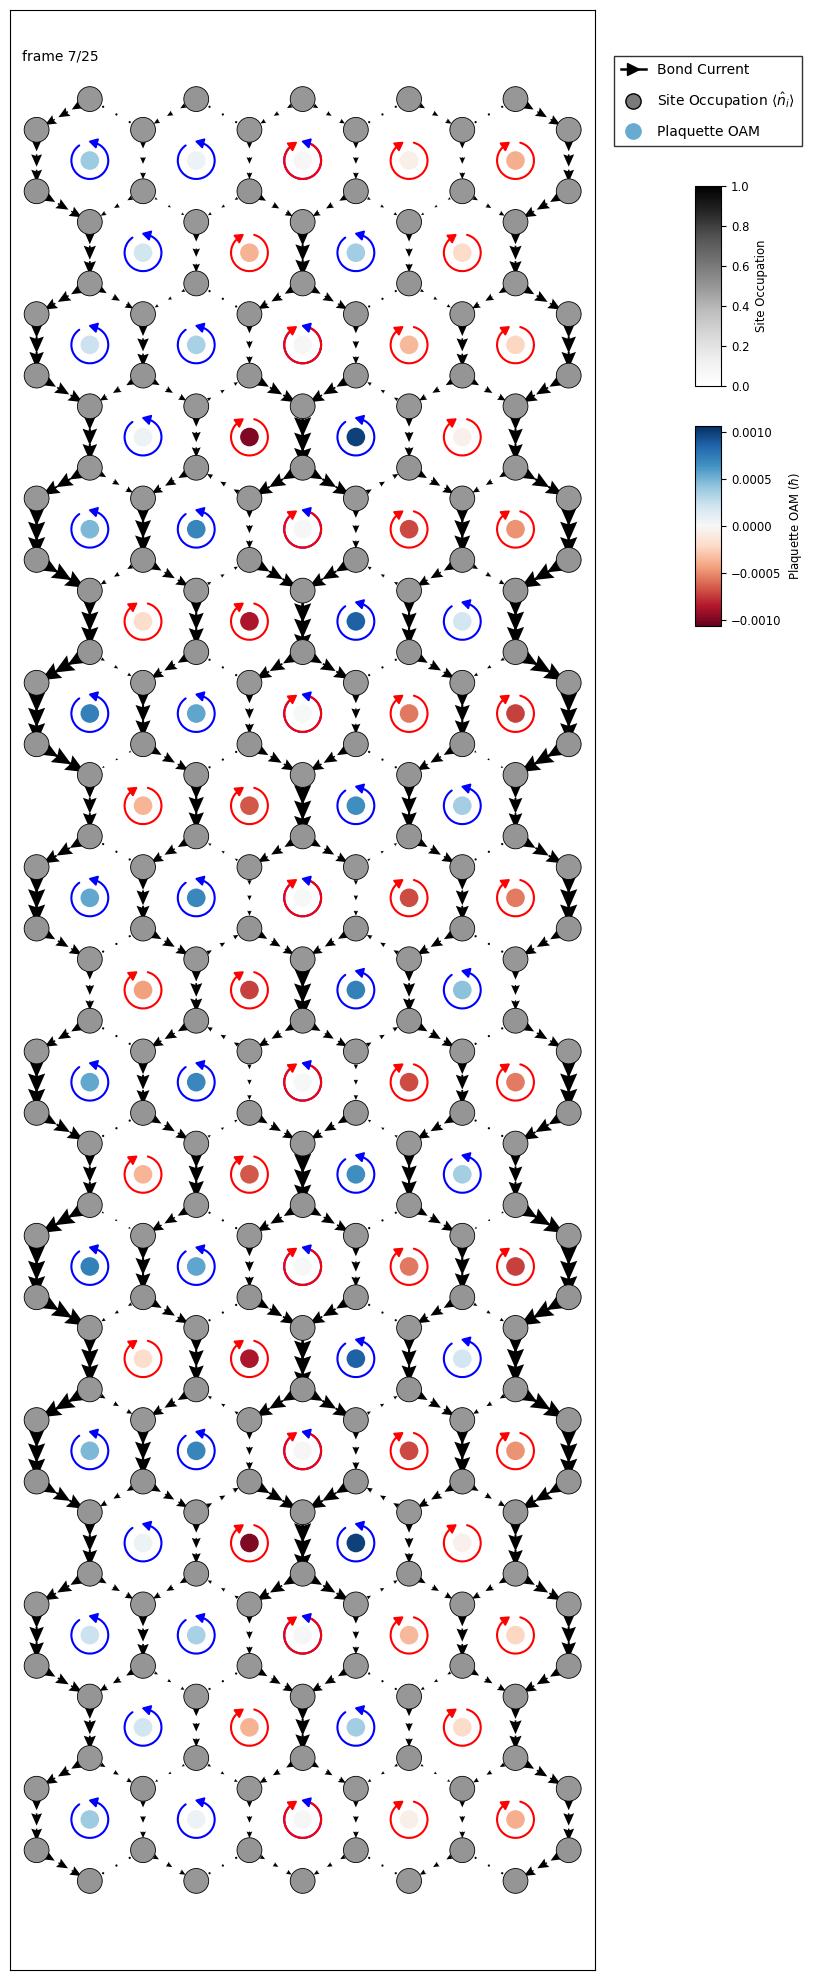

In [7]:
# Plot the ith frame of the animation and save it as PNG
i = 6
orb2d.show_simulation_frame(animation, frame=i, show=False)
plt.savefig(f"frame{i}.png")
plt.show()

In [8]:
# Save a video animation of the animation frames recorded during the last period
orb2d.save_simulation_animation(animation, out_path="animation.mp4")

In [14]:
# Calculate orbital hall conductivity from polarization current
P_x = orb_pol.values[:, 0]
t = orb_pol.measurement_times
orb_current = np.diff(P_x) / np.diff(t)  # discrete time derivative

if tb.backend.USE_GPU:
    # at_time methods are backend aware, so we convert to and from cupy if on GPU
    E = H.field_amplitude.at_time(tb.backend.xp().array(t[:-1])).get()
else:
    E = H.field_amplitude.at_time(t[:-1])

sigma_orb_xy = orb2d.ohc(orb_current, E, t[1] - t[0], H.field_amplitude.omega)

print(
    f"Absolute OHC {abs(sigma_orb_xy):.2f} e/2pi, phase {np.angle(sigma_orb_xy):.2f} rad"
)

Absolute OHC 0.79 e/2pi, phase -2.41 rad
